# Preprocessing of data

### Import libraries and preproc

In [4]:
import sys
import numpy as np
from tqdm import tqdm
import nibabel
#!{sys.executable} -m pip install nilearn #install relevant neuroimaging package
#!{sys.executable} -m pip install opencv-python #install video package
from preprocessing import load_and_mask_miyawaki_data
from plots import plt_fmri_stim
import matplotlib.pyplot as plt

In [5]:
fmri_data, stimuli, fmri_figures_data, stimuli_figures, masker = load_and_mask_miyawaki_data()

Preprocessing data...

The shape of the masked data is (20, 145, 5438)
Preprocessed fMRI data: 2860 samples x 5438 voxels
Preprocessed stimuli data: 2860 samples x 100 pixels
1536 geometrical figures


 Done (21.20s).


### Create data sets

In [391]:
from sklearn.model_selection import train_test_split

# Random images avec les carrés noirs : train and validation set
train_to_test_ratio = 0.7
X_train, X_val, Y_train, Y_val = train_test_split(fmri_data, stimuli, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

# Test set : geometric images
X_test, Y_test = fmri_figures_data, stimuli_figures

### Manipulate stimuli images for multiscale analysis

In [392]:
# Create list pixel_indices of 4-uplets of incidices of pixels we want to average together for the 2*2 scale
n_even = [2*i for i in range(5)] #list used to generate pixel_indices
#pixel_indices_22 = [[10*a+b, 10*a+(b+1), 10*(a+1)+b, 10*(a+1)+(b+1)] for a in n_even for b in n_even]
pixel_indices_22 = [[10*a+b, 10*a+(b+1), 10*(a+1)+b, 10*(a+1)+(b+1)] for a in range(9) for b in range(9)]

# Same for 2*1 scale
n_odd = [2*i+1 for i in range(50)]
#pixel_indices_21 = [[a-1, a] for a in n_odd]
pixel_indices_21 = [[(10*b)+ a-1, 10*b + a] for b in range(10) for a in range(10)[1:]]

# Same for 1*2 scale
#pixel_indices_12 = [[a*10 + b, (a+1)*10 +b] for a in n_even for b in range(10)]
pixel_indices_12 = [[a*10 + b, (a+1)*10 +b] for a in range(9) for b in range(10)]

In [393]:
# Preprocessing of stimuli data for multi scale encoding

def preproc_one_stimuli(idx_pxl_toavg, stim, reshape = False, reshape_form = (5,5)) :
    """
    Permits to preproc 1 stimuli figure by averaging some pixels together for the 
    multiscale encoding.
    - idx_pxl_toavg : liste de multiplets d'indices de pixels que l'on souhaite moyenner
                      ensemble. Par ex, pour le 2*2 on a :
                      [[0,1,10,11], [2,3,12,13], ... ,[88,89,98,99]].
    - stimuli: the image
    - reshape : if you want your image to be reshaped in such a way that you can plot it
    - reshape_form : (5,5) for a 5 by 5 image, etc...
    """
    if reshape == False :
        return np.array([np.average([stim[i] for i in idx]) for idx in idx_pxl_toavg])
    
    else :
        return np.array(np.reshape([np.average([stim[i] for i in idx]) for idx in idx_pxl_toavg],reshape_form))
    

def preproc_multiple_stimuli(idx_pxl_toavg, stimuli_list, reshape = False, reshape_form = (5,5)) :
    """
    Same as above but to preproc a whole list of stimulis
    Sorry this looks horrible
    """
    if reshape == False :
        return np.array([[np.average([stim[i] for i in idx]) for idx in idx_pxl_toavg] for stim in stimuli_list])
    
    else :
        reshape_form_multi = (len(stimuli_list),reshape_form[0],reshape_form[1])
        return np.array(np.reshape([np.average([stim[i] for i in idx]) for idx in idx_pxl_toavg for stim in stimuli_list],reshape_form_multi))
    
def Y_train_newscale(Y_train, idx_pxl_toavg, reshape = False, reshape_form = (5,5)) :
    """
    Creates a new Y_train but with rescaled images 
    Changes greyscale values to classes (integers) : for this, we want to map the values of greyscale to
    integers. We notice that for 4 pixels, only possible values are [0,0.25,0.5,0.75,1]. For 2 pixels, [0,0.5,1]. Etc.
    By multiplying these grayscale values by the number of pixels we get [0,1,2,3,4] or [0,1,2], etc. Hence the multiplication.
    """
    Y_continuous = preproc_multiple_stimuli(idx_pxl_toavg, Y_train, reshape, reshape_form) #with values in [0,1]
    n = len(idx_pxl_toavg[0]) #number of classes is the number of pixels there is to average + 1. For instance for 4 pixels you can have [0,0.25,0.5,0.75,1]
    Y_integers = [[int(pixel_val * n) for pixel_val in img] for img in Y_continuous]
    return Y_integers

# Check that stimuli processing works

imag = stimuli_figures2[30]

old = np.reshape(imag,(10,10))
new = preproc_one_stimuli(pixel_indices_22, imag, reshape = True)

fig = plt.figure()
sp1 = plt.subplot(121)
sp2 = plt.subplot(122)

# to show the grid 

for ax in (sp1, sp2) :

    # Major ticks
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
    
    ax.grid(which='minor', color='r', linestyle='-', linewidth=2)


sp1.imshow(old, cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(new, cmap = plt.cm.gray, interpolation = 'nearest')

It works !

# Train a log reg at the different scales

In [394]:
from sklearn import linear_model

def train_logreg_scale(x_train, y_train, x_test, y_test, scale) :
    """
    Trains a log reg for a certain scale 
    """
    logreg_table = []
    size = len(y_train[0])
    
    train_accuracy, test_accuracy = np.zeros(size), np.zeros(size)
    print(len(train_accuracy))

    # loop over regularisation strength
    for i, pixel in tqdm(enumerate(np.transpose(y_train))):
    
        # define logistic regressor
        logreg = linear_model.LogisticRegression(penalty="l2", C=0.05, max_iter = 15000, multi_class='multinomial')#, n_jobs = 2)#, n_jobs=-1)
    
        # fit training data
        logreg.fit(x_train, pixel)
    
        logreg_table.append(logreg)
    
        # check accuracy
        train_accuracy[i]=logreg.score(x_train,pixel)
        test_accuracy[i]=logreg.score(x_test,np.transpose(y_test)[i])
        
    return logreg_table, train_accuracy, test_accuracy

In [395]:
#Prediction functions for initial pixels
[logreg_table_11, train_accuracy_11, test_accuracy_11] = train_logreg_scale(X_train, Y_train, X_test, Y_test, (1,1))

0it [00:00, ?it/s]

100


100it [15:22,  9.22s/it]


In [396]:
print(np.average(train_accuracy_11), np.average(test_accuracy_11))

1.0 0.8824414062500001


In [397]:
# New Y_train for 2*2 block averaged images
Y_train_22, Y_test_22 = Y_train_newscale(Y_train, pixel_indices_22), Y_train_newscale(Y_test, pixel_indices_22)

[logreg_table_22, train_accuracy_22, test_accuracy_22] = train_logreg_scale(X_train, Y_train_22, X_test, Y_test_22,(2,2))

0it [00:00, ?it/s]

81


81it [38:50, 28.77s/it]


In [399]:
print(np.average(train_accuracy_22), np.average(test_accuracy_22))

1.0 0.6879501028806584


81
81


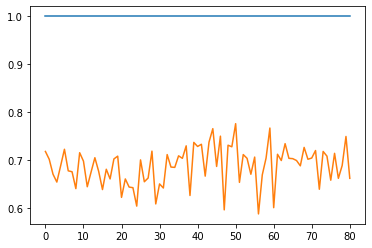

In [400]:
fig, ax = plt.subplots() #try to see test accuracy function of pixel
plt.plot(range(len(train_accuracy_22)),train_accuracy_22)
plt.plot(range(len(test_accuracy_22)), test_accuracy_22)
print(len(Y_train_22[0]))
print(len(train_accuracy_22))

In [401]:
# New Y_train for 2*1 block averaged images
Y_train_21, Y_test_21 = Y_train_newscale(Y_train, pixel_indices_21),  Y_train_newscale(Y_test, pixel_indices_21)
            
[logreg_table_21, train_accuracy_21, test_accuracy_21] = train_logreg_scale(X_train, Y_train_21, X_test, Y_test_21,(2,1))

0it [00:00, ?it/s]

90


90it [25:48, 17.20s/it]


In [402]:
print(np.average(train_accuracy_21), np.average(test_accuracy_21))

1.0 0.7951967592592593


In [403]:
# New Y_train for 1*2 block averaged images
Y_train_12, Y_test_12 = Y_train_newscale(Y_train, pixel_indices_12),  Y_train_newscale(Y_test, pixel_indices_12)

[logreg_table_12, train_accuracy_12, test_accuracy_12] = train_logreg_scale(X_train, Y_train_12, X_test, Y_test_12,(1,2))

0it [00:00, ?it/s]

90


0it [00:28, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(np.average(train_accuracy_12), np.average(test_accuracy_12))
len(Y_train_12[0])

# Check results 

In [144]:
def block_to_100px(y_block, pixel_indices_shape, normalize = True) :
    """
    Make the y_block list of overlapping block averaged images with shape nxm 
    (2x2, 2x1 or 1x2) to a list of 100-pixels images. The contributions of overlapping
    blocks are simply averaged for each pixel, with equal weights for each block.
    
    FINAL IMAGE HAS VALUES BETWEEN 0 (black) AND 1 (white) IF NORMALIZE = TRUE
    
    - y_block : list of block values for (predicted or not) images
    - shape : shape of block (2*1 is (2,1) for instance)
    - pixel_indices_shape : list of pixel indices contained in each block (e.g. the first
      block of 2x2 block avgd image contains pixels of indices [0,1,10,11])
    """

    # First, depending on the format, we make a list of the indices of the 
    # blocks we need to average toegether (since not all pixels have the same
    # number of blocks contributing --- and also that their locations are not obvious)
    # block_to_avg[i] : indices of blocks to avg together to make pixel i
    
    block_to_avg = []
    for pixel in range(100) : 
        pixel_blocks = []
        for i, block in enumerate(pixel_indices_shape) :
            if pixel in block :
                pixel_blocks.append(i)
        block_to_avg.append(pixel_blocks)

    # Now we make each image a 100-pixels image instead of a several overlapping blocks
    # image
    
    if normalize == True :
        y_100 = [[np.average([img[block] for block in block_to_avg[pixel]]) for pixel in range(100)] for img in y_block]
        y_100 = [[x/max(img) if max(img) != 0 else 0 for x in img] for img in y_100]
    else :
        y_100 = [[np.average([img[block] for block in block_to_avg[pixel]]) for pixel in range(100)] for img in y_block]
    
    return np.array(y_100)

def weighted_sum(weights, images, i) :
    """
    Just a linear combination of values of different images given different weights
    """
    # i : indice of pixel
    [W11, W12, W21, W22] = weights
    [im11, im12, im21, im22] = images
    return W11[i] * im11[i] + W12[i] * im12[i] + W21[i] * im21[i] + W22[i] * im22[i]

def avgd_imag(weights, images) :
    """
    Averages 4 images given the weights for each pixel for each pixel of each kind of img
    """
    return np.array([weighted_sum(W, imgs, px) for px in range(100)])

def avg_all_images(weights, images) :
    """
    Averages all images 4 by 4 with the corresponding weights
    """
    [y11, y12, y21, y22] = images #predictions of images 
    #[w11, w12, w21, w22] = weights
    groups = [[y11[i],y12[i],y21[i],y22[i]] for i in range(len(y11))] #groups of predicted images corresponding to the same fMRI
    return np.array([avgd_imag(weights, groups[i]) for i in range(len(groups))])

# Make predictions on the geometrical shapes dataset to see how it looks

In [ ]:
def predict_from_fmri(logregtable, X) :
    """
    Predicts images of different block averaging types (the 4 of them) given a X
    """
    pred_list = []

    for x in X :
        x = np.reshape(x,(1,-1))
        pred = []
        for block in range(len(logregtable)) :
            block_pred = logregtable[block].predict(x)
            pred.append(block_pred)
        pred_list.append(pred)
    
    flattened_list = [np.array(a).flatten for a in pred_list]
    
    return pred_list

In [263]:
# Predictions from fmri_figures_data
ypred_22 = predict_from_fmri(logreg_table_22, fmri_figures_data)
ypred_12 = predict_from_fmri(logreg_table_12, fmri_figures_data)
ypred_21 = predict_from_fmri(logreg_table_21, fmri_figures_data)
ypred_11 = predict_from_fmri(logreg_table_11, fmri_figures_data)

In [265]:
ypred22 = block_to_100px(ypred_22, pixel_indices_22)
ypred21 = block_to_100px(ypred_21, pixel_indices_21)
ypred12 = block_to_100px(ypred_12, pixel_indices_12)
ypred11 = ypred_11

### Try to plot some

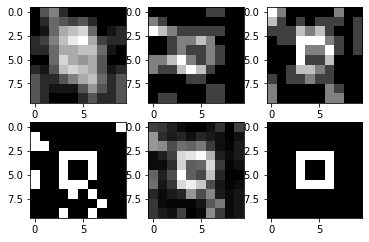

In [298]:
n = 25

w11 = np.ones(100) * 0.25
w22 = np.ones(100) * 0.25
w21 = np.ones(100) * 0.25 
w12 = np.ones(100) * 0.25

W = [w11, w12, w21, w22]
imgs = [ypred11[n], ypred12[n], ypred21[n], ypred22[n]]
#print(imgs, np.shape(imgs))
true = np.reshape(stimuli_figures[n],(10,10))

averaged = []

def weighted_sum(weights, images, i) :
    # i : indice of pixel
    [W11, W12, W21, W22] = weights
    [im11, im12, im21, im22] = images
    return W11[i] * im11[i] + W12[i] * im12[i] + W21[i] * im21[i] + W22[i] * im22[i]

def avgd_imag(weights, images, binarized = False) :
    if binarized == False :
        return np.array([weighted_sum(weights, images, px) for px in range(100)])
    else :
        return np.array([np.round(weighted_sum(weights, images, px),0) for px in range(100)])

averaged = avgd_imag(W, imgs)
    
fig = plt.figure(figsize=(6,6))
sp1 = plt.subplot(331)
sp2 = plt.subplot(332)
sp3 = plt.subplot(333)
sp4 = plt.subplot(334)
sp5 = plt.subplot(335)
sp6 = plt.subplot(336)
sp1.imshow(np.reshape(ypred22[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(np.reshape(ypred21[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp3.imshow(np.reshape(ypred12[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp4.imshow(np.reshape(ypred11[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp5.imshow(np.reshape(averaged,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')   
sp6.imshow(np.reshape(stimuli_figures[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')       

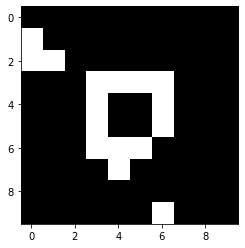

In [270]:
binarized = avgd_imag(W, imgs, binarized = True)
plt.imshow(np.reshape(binarized,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')

# Now let's optimize the shit out of the weights

### First, we make the predictions on the validation set, made of random images (30%) (validation set = optimization of hyperparameters)
We use the previously trained logregs for this.
Next, we will use a linear regression that tries to find the best weights to assign to each type (2x2, 2x1, 1x2 and 1x1) of prediction to get a final summed image as close as possible from the original one.

In [300]:
# valing set predictions of geometric shapes data set
pred_val_22 = predict_from_fmri(logreg_table_22, X_val)
pred_val_12 = predict_from_fmri(logreg_table_12, X_val)
pred_val_21 = predict_from_fmri(logreg_table_21, X_val)
pred_val_11 = predict_from_fmri(logreg_table_11, X_val)

In [302]:
pred_train22 = block_to_100px(pred_train_22, pixel_indices_22)
pred_train21 = block_to_100px(pred_train_21, pixel_indices_21)
pred_train12 = block_to_100px(pred_train_12, pixel_indices_12)
pred_train11 = pred_train_11

We plot those predictions, just to see what they look like. In principle, if the logregs are well trained, we should (even with the guessed weights we put there, not the optimized ones) find something coherent, since the test accuracy was not bad previously.

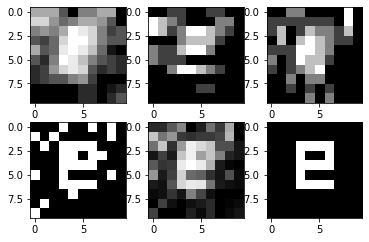

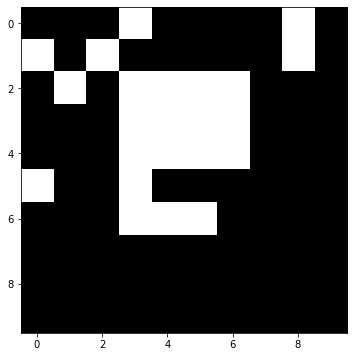

In [381]:
n = 14

im = [pred_val11[n], pred_val12[n], pred_val21[n], pred_val22[n]]

av = avgd_imag(W, im)#avgd_imag(np.transpose(coeffs), im)
binar = avgd_imag(W, im, binarized = True)

fig = plt.figure(figsize=(6,6))
sp1 = plt.subplot(331)
sp2 = plt.subplot(332)
sp3 = plt.subplot(333)
sp4 = plt.subplot(334)
sp5 = plt.subplot(335)
sp6 = plt.subplot(336)

sp1.imshow(np.reshape(pred_val22[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(np.reshape(pred_val21[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp3.imshow(np.reshape(pred_val12[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp4.imshow(np.reshape(pred_val11[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp5.imshow(np.reshape(av,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')   
sp6.imshow(np.reshape(Y_val[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')     

fig2 = plt.figure(figsize=(6,6))
sp = plt.subplot(111)
sp.imshow(np.reshape(binar,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')

We indeed have something coherent. Now, we want to optimize the weights.

For this, we train a linear regression that will try and sum the contributions of all 4 predictions (2x2, 1x2, 2x1 and 1x1 block averaged preds) for each fMRI with weights that will be pixel-dependant. The linear regression will optimize the weights such that the weighted sum of the block averaged predictions give a final image as close as possible to the final one. *In that case, we do not consider the binarized image. Maybe we should.*

In [368]:
# So we do the linear regression trying to have a sum of predicted images
# of the validation set as close as possible to the true value

preds = np.array([pred_val22, pred_val21, pred_val12, pred_val11])

linreg = []
coeffs = []

for pixel in range(100) :
    px_pred = [[img[pixel] for img in y] for y in preds]
    px_pred = np.transpose(px_pred)
    px_yval = [img[pixel] for img in Y_valg]
    
    model = LinearRegression().fit(px_pred, px_yval)
    linreg.append(model)
    coeffs.append(model.coef_)    

# Now check on the TEST set made of geometrical shapes

In [305]:
pred_test_22 = predict_from_fmri(logreg_table_22, X_test)
pred_test_12 = predict_from_fmri(logreg_table_12, X_test)
pred_test_21 = predict_from_fmri(logreg_table_21, X_test)
pred_test_11 = predict_from_fmri(logreg_table_11, X_test)

In [307]:
pred_test22 = block_to_100px(pred_test_22, pixel_indices_22)
pred_test21 = block_to_100px(pred_test_21, pixel_indices_21)
pred_test12 = block_to_100px(pred_test_12, pixel_indices_12)
pred_test11 = pred_test_11

In [308]:
np.shape(coeffs)

(100, 4)

Now, we plot the results on the test set, using the optimized weights, and see if that looks good 

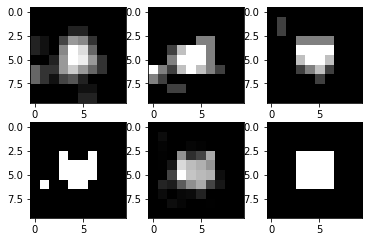

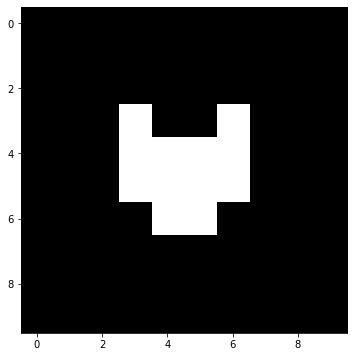

In [389]:
n = 49

im = [pred_test11[n], pred_test12[n], pred_test21[n], pred_test22[n]]

av = avgd_imag(np.transpose(coeffs), im)
binar = avgd_imag(np.transpose(coeffs), im, binarized = True)

fig = plt.figure(figsize=(6,6))
sp1 = plt.subplot(331)
sp2 = plt.subplot(332)
sp3 = plt.subplot(333)
sp4 = plt.subplot(334)
sp5 = plt.subplot(335)
sp6 = plt.subplot(336)

sp1.imshow(np.reshape(pred_test22[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(np.reshape(pred_test21[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp3.imshow(np.reshape(pred_test12[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp4.imshow(np.reshape(pred_test11[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')
sp5.imshow(np.reshape(av,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')   
sp6.imshow(np.reshape(Y_test[n],(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')     

fig2 = plt.figure(figsize=(6,6))
sp = plt.subplot(111)
sp.imshow(np.reshape(binar,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest')

# Let's look at accuracy and all the shit (because we kind of have to)

 Statistics on the logistic regressions,
 statistics on the weights

In [358]:
# "images" whose pixels have value the weight assigned 
weight11, weight22, weight21, weight12 = [], [], [], []

for [w11, w12, w21, w22] in coeffs :
    weight11.append(w11)
    weight22.append(w22)
    weight12.append(w12)
    weight21.append(w21)
    
wmax = max([x[j] for x in coeffs for j in range(4)])
wmin = min([x[j] for x in coeffs for j in range(4)])
wmin, wmax

(-0.20080641370610586, 0.7077821691138432)

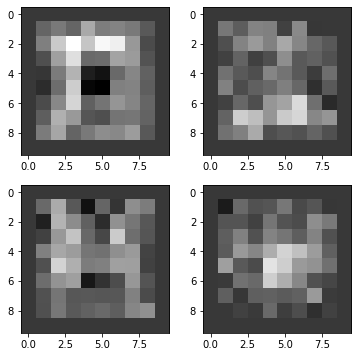

In [369]:
fig = plt.figure(figsize=(6,6))
sp1 = plt.subplot(221)
sp2 = plt.subplot(222)
sp3 = plt.subplot(223)
sp4 = plt.subplot(224)

sp1.imshow(np.reshape(weight11,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', label="truc", vmin = wmin, vmax = wmax)
sp2.imshow(np.reshape(weight12,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = wmin, vmax = wmax)
sp3.imshow(np.reshape(weight21,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest',vmin = wmin, vmax = wmax)
sp4.imshow(np.reshape(weight22,(10,10)),  cmap = plt.cm.gray, interpolation = 'nearest', vmin = wmin, vmax = wmax)

These are the weights for each pixel and for each kind of block averaging